**классификатор изображений на основе VGG16**

Евгений Борисов <esborisov@sevsu.ru>

---

VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION   
Karen Simonyan, Andrew Zisserman    
Visual Geometry Group, Department of Engineering Science, University of Oxford   

https://arxiv.org/pdf/1409.1556.pdf

---

In [1]:
from os import listdir
from os.path import join as pjoin

import numpy as np
from PIL import Image

from matplotlib import pyplot as plt

## модель

In [2]:
from tabulate import tabulate
import tensorflow as tf
from tensorflow.test import is_built_with_cuda
from tensorflow.python.client.device_lib import list_local_devices

def tf_info(tablefmt='html'):
    res = [ ['tensorflow','%s'%(tf.__version__)],['keras','%s'%(tf.keras.__version__)] ]
    if is_built_with_cuda():
        res.extend( [ 
              [ s.strip().split(': ') for s in d.physical_device_desc.split(',')  ]
               for d in list_local_devices() 
              if d.device_type == 'GPU' # and d.name==tf.test.gpu_device_name()
            ][0] )
    else:
        res.append(['','no CUDA support'])
    return tabulate( res, tablefmt=tablefmt )

tf_info()


tensorflow,2.4.1
keras,2.4.0
device,0
name,NVIDIA GeForce GTX 1060 6GB
pci bus id,0000:01:00.0
compute capability,6.1


## загружаем модель

In [3]:
# !mkdir -p ../data/imagenet
# !wget -P ../data/imagenet -c https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels.h5

# WEIGHTS_VGG16='data/imagenet/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
# model = VGG16(weights=WEIGHTS_VGG16)

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model

In [5]:
model = VGG16() # автозагрузка весов

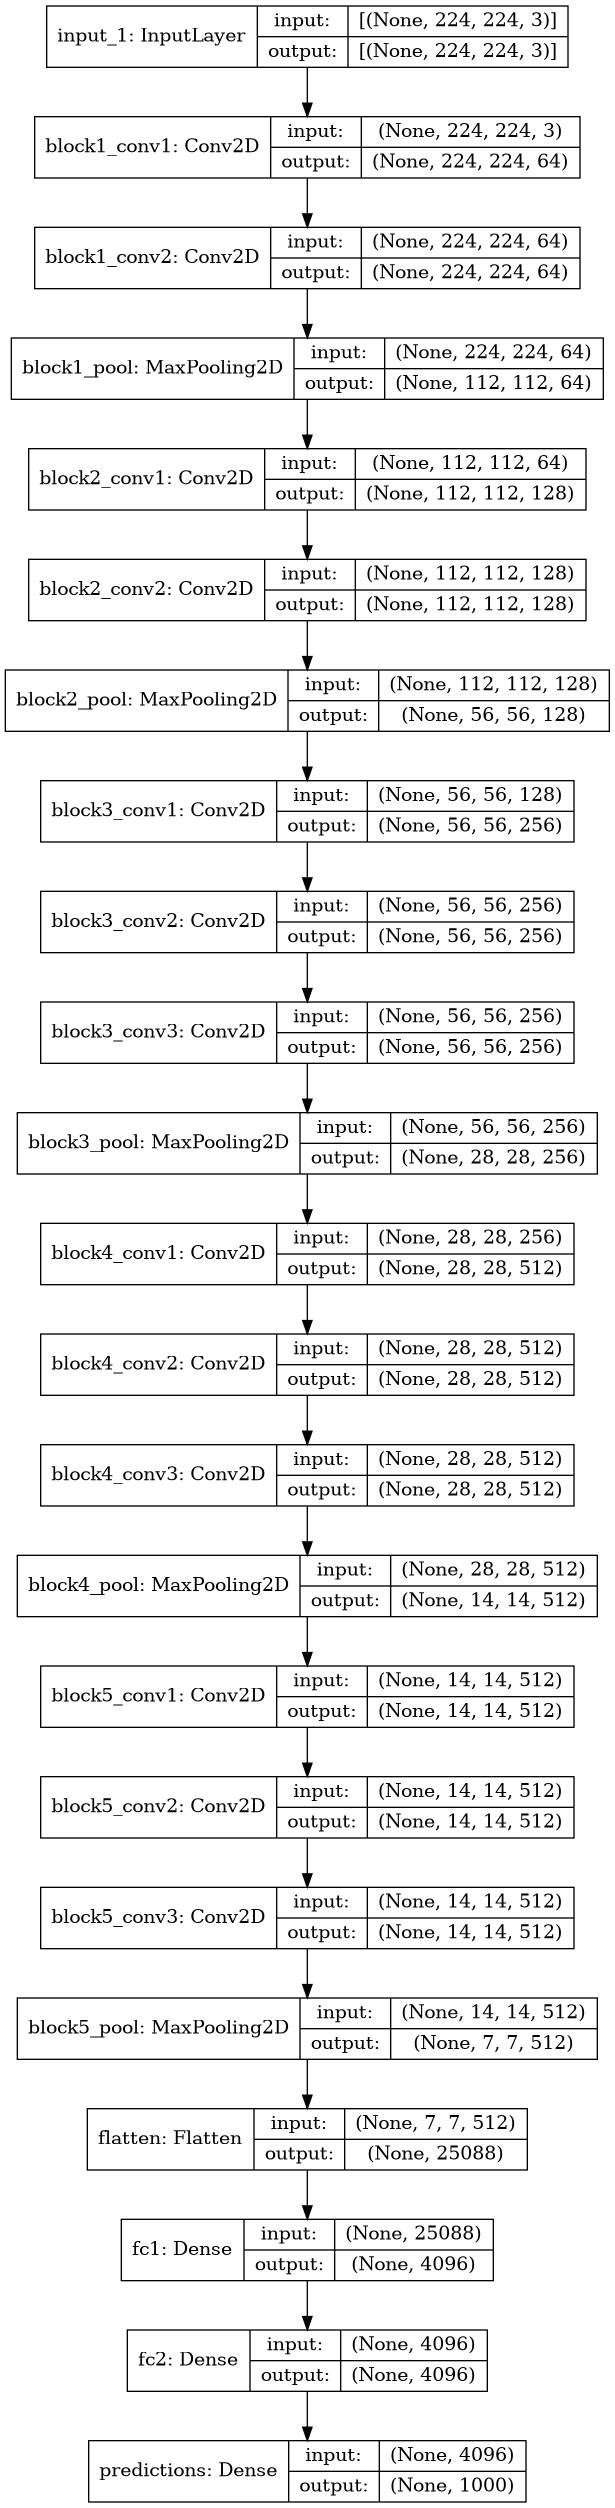

In [6]:
plot_model(model, to_file='vgg16.png', show_layer_names=True, show_shapes=True )

## тестируем

In [7]:
# имена классов imagenet1000
# !wget -P ../data/imagenet -c https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt

In [8]:
# http://www.image-net.org

fname_labels = '../data/imagenet/imagenet1000_clsidx_to_labels.txt'
with open(fname_labels, 'rt') as f:   imagenet_labels = eval(f.read())

image_folder ='../data/imagenet/photos/'
files = listdir(image_folder)

# def normalize(x):
#     x_mx,x_mn = x.max(axis=(1,2,3),keepdims=1), x.min(axis=(1,2,3),keepdims=1) 
#     return ((x-x_mn)/(x_mx-x_mn)).astype(np.float32)
#     # return np.transpose( ((x-x_mn)/(x_mx-x_mn)), axes=(0,3,1,2) ) 

def image2arr(im):
    return np.array(im.resize([224,224,]).convert('RGB')).astype(np.float32)[np.newaxis,:]

x = np.vstack([image2arr(Image.open(pjoin(image_folder,f))) for f in files])

In [9]:
def draw_images(
        x, # numpy тензор с картинками
        y=[], # метки классов
        class_names=None, # имена классов
        columns=3, # количество колонок в таблице с картинками  
        fig_width=14, # ширина таблицы с картинками
        num_ex=0, # рисуем только первые num_ex
        max_title_len=25 # максимальная длинна заголовка картинки
    ):
    # рисуем данные
    n_img = min(x.shape[0],num_ex) if num_ex>0 else x.shape[0]  # количество картинок для отображения
    col = columns # количество колонок
    w = fig_width # ширина таблицы с картинками
    h = (n_img//col)*(w//col) # высота таблицы с картинками

    fig = plt.figure(figsize=(w,h))
    for n in range(n_img):
        img = x[n,:] # извлекаем одну картинку
        plt.subplot(n_img//col+1,col,n+1) # создаём ячейку таблицы
        plt.axis(False) # оси координат не рисуем
        if len(y)==x.shape[0]:
            t = class_names[y[n]] # имя класса картинки
            t = t if len(t)<(max_title_len+1) else t[:max_title_len]+'...'
            plt.title(t) # заголовок картинки
        plt.imshow(img) # рисуем картинку
    fig.tight_layout() # выравниваем элементы таблицы


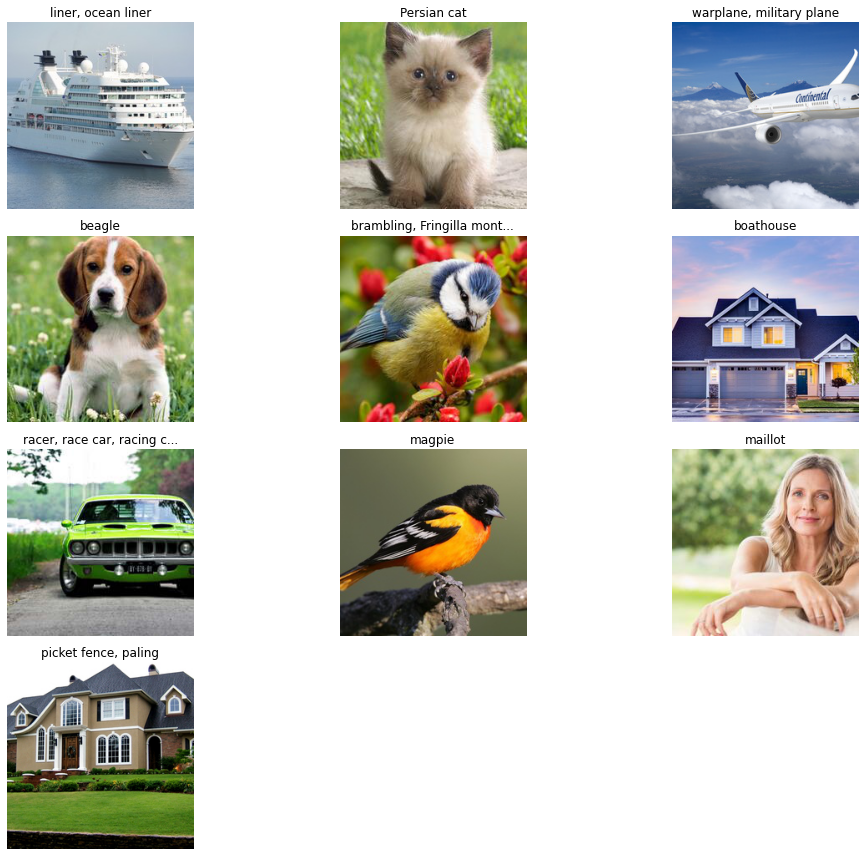

In [10]:
o = model.predict(x)
y = np.argmax(o,axis=1)
draw_images(x.astype(np.uint8),y, imagenet_labels )